In [28]:
# Phase 4: Machine Learning Implementation for Bearing Failure Prediction
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

In [3]:
df = pd.read_csv("bearing_features.csv")

In [4]:
# Let's get familiar with our dataset
print("Dataset shape:", df.shape)
print("\nColumns in our dataset:")
for col in df.columns:
    print(f"- {col}")

print("\nDistribution of failure types:")
print(df['failure_type'].value_counts())

Dataset shape: (753, 23)

Columns in our dataset:
- low_rms
- low_peak
- low_crest
- low_kurtosis
- mid_rms
- mid_peak
- mid_crest
- mid_kurtosis
- high_rms
- high_peak
- high_crest
- high_kurtosis
- degradation_mid_to_baseline_ratio
- degradation_late_to_baseline_ratio
- degradation_early_rate
- degradation_mid_rate
- degradation_late_rate
- degradation_early_stability
- degradation_mid_stability
- degradation_late_stability
- failure_type
- channel
- sample_number

Distribution of failure types:
failure_type
outer_race_set3    316
inner_race         214
roller             174
outer_race_set2     49
Name: count, dtype: int64


In [8]:
# Create bearing identifiers - treating channels of the same bearing together
df['bearing_id'] = df.apply(lambda row: 
    # Set 1: Combine channels for each bearing
    f"{row['failure_type']}_bearing3" if row['channel'] in ['Ch5', 'Ch6'] else  # Bearing 3 (inner race)
    f"{row['failure_type']}_bearing4" if row['channel'] in ['Ch7', 'Ch8'] else  # Bearing 4 (roller)
    # Set 2 & 3: Keep as is since one channel per bearing
    f"{row['failure_type']}_bearing1" if 'outer_race_set2' in row['failure_type'] else  # Set 2 Bearing 1
    f"{row['failure_type']}_bearing3",  # Set 3 Bearing 3
    axis=1)

# Calculate time to failure per bearing
df['time_to_failure'] = df.groupby('bearing_id')['sample_number'].transform(
    lambda x: x.max() - x
)

print("Sample of bearing-based time_to_failure values:")
print(df[['failure_type', 'channel', 'bearing_id', 'sample_number', 'time_to_failure']].sort_values(['bearing_id', 'channel', 'sample_number']).head(15))

Sample of bearing-based time_to_failure values:
   failure_type channel           bearing_id  sample_number  time_to_failure
0    inner_race     Ch5  inner_race_bearing3              0             2155
2    inner_race     Ch5  inner_race_bearing3             20             2135
4    inner_race     Ch5  inner_race_bearing3             40             2115
6    inner_race     Ch5  inner_race_bearing3             60             2095
8    inner_race     Ch5  inner_race_bearing3             81             2074
10   inner_race     Ch5  inner_race_bearing3            101             2054
12   inner_race     Ch5  inner_race_bearing3            121             2034
14   inner_race     Ch5  inner_race_bearing3            142             2013
16   inner_race     Ch5  inner_race_bearing3            162             1993
18   inner_race     Ch5  inner_race_bearing3            182             1973
20   inner_race     Ch5  inner_race_bearing3            203             1952
22   inner_race     Ch5  inn

In [9]:
# Print samples from each bearing configuration
print("Samples from Set 1 Bearing 3 (both channels):")
print(df[df['bearing_id'] == 'inner_race_bearing3'][['failure_type', 'channel', 'bearing_id', 'sample_number', 'time_to_failure']].head(6))

print("\nSamples from Set 1 Bearing 4 (both channels):")
print(df[df['bearing_id'] == 'roller_bearing4'][['failure_type', 'channel', 'bearing_id', 'sample_number', 'time_to_failure']].head(6))

print("\nSamples from Set 2 Bearing 1:")
print(df[df['bearing_id'] == 'outer_race_set2_bearing1'][['failure_type', 'channel', 'bearing_id', 'sample_number', 'time_to_failure']].head(3))

print("\nSamples from Set 3 Bearing 3:")
print(df[df['bearing_id'] == 'outer_race_set3_bearing3'][['failure_type', 'channel', 'bearing_id', 'sample_number', 'time_to_failure']].head(3))

Samples from Set 1 Bearing 3 (both channels):
  failure_type channel           bearing_id  sample_number  time_to_failure
0   inner_race     Ch5  inner_race_bearing3              0             2155
1   inner_race     Ch6  inner_race_bearing3              0             2155
2   inner_race     Ch5  inner_race_bearing3             20             2135
3   inner_race     Ch6  inner_race_bearing3             20             2135
4   inner_race     Ch5  inner_race_bearing3             40             2115
5   inner_race     Ch6  inner_race_bearing3             40             2115

Samples from Set 1 Bearing 4 (both channels):
    failure_type channel       bearing_id  sample_number  time_to_failure
214       roller     Ch7  roller_bearing4              0             1752
215       roller     Ch8  roller_bearing4              0             1752
216       roller     Ch7  roller_bearing4             20             1732
217       roller     Ch8  roller_bearing4             20             1732
218  

In [10]:
# Get our feature columns, excluding non-predictive ones
feature_columns = [col for col in df.columns if col not in ['time_to_failure', 'failure_type', 'channel', 'sample_number', 'bearing_id']]

# Create our feature matrix X and target variable y
X = df[feature_columns]
y = df['time_to_failure']

print("Features we'll use for prediction:")
for feature in feature_columns:
    print(f"- {feature}")

print(f"\nShape of feature matrix X: {X.shape}")
print(f"Shape of target variable y: {y.shape}")

Features we'll use for prediction:
- low_rms
- low_peak
- low_crest
- low_kurtosis
- mid_rms
- mid_peak
- mid_crest
- mid_kurtosis
- high_rms
- high_peak
- high_crest
- high_kurtosis
- degradation_mid_to_baseline_ratio
- degradation_late_to_baseline_ratio
- degradation_early_rate
- degradation_mid_rate
- degradation_late_rate
- degradation_early_stability
- degradation_mid_stability
- degradation_late_stability

Shape of feature matrix X: (753, 20)
Shape of target variable y: (753,)


In [11]:
# Convert time_to_failure from measurements to hours
# Since measurements are taken every 10 minutes, we multiply by 10 and divide by 60
df['time_to_failure_hours'] = (df['time_to_failure'] * 10) / 60

print("Sample of time-to-failure in measurements vs hours:")
print(df[['bearing_id', 'time_to_failure', 'time_to_failure_hours']].head(10))
print("\nMaximum time to failure for each bearing (in hours):")
print(df.groupby('bearing_id')['time_to_failure_hours'].max())

Sample of time-to-failure in measurements vs hours:
            bearing_id  time_to_failure  time_to_failure_hours
0  inner_race_bearing3             2155             359.166667
1  inner_race_bearing3             2155             359.166667
2  inner_race_bearing3             2135             355.833333
3  inner_race_bearing3             2135             355.833333
4  inner_race_bearing3             2115             352.500000
5  inner_race_bearing3             2115             352.500000
6  inner_race_bearing3             2095             349.166667
7  inner_race_bearing3             2095             349.166667
8  inner_race_bearing3             2074             345.666667
9  inner_race_bearing3             2074             345.666667

Maximum time to failure for each bearing (in hours):
bearing_id
inner_race_bearing3          359.166667
outer_race_set2_bearing1     163.833333
outer_race_set3_bearing3    1053.833333
roller_bearing4              292.000000
Name: time_to_failure_hours, d

In [12]:
# Now create our final X and y with hours as our prediction target
feature_columns = [col for col in df.columns if col not in ['time_to_failure', 'time_to_failure_hours', 'failure_type', 'channel', 'sample_number', 'bearing_id']]

X = df[feature_columns]
y = df['time_to_failure_hours']  # Using hours instead of measurement counts

print("\nConfirming our final shapes:")
print(f"Feature matrix X shape: {X.shape}")
print(f"Target variable y shape: {y.shape}")


Confirming our final shapes:
Feature matrix X shape: (753, 20)
Target variable y shape: (753,)


In [13]:

# First split: separate out our test set (15% of data)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.15,  # 15% for final testing
    random_state=42  # for reproducibility
)

# Second split: divide remaining data into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.15,  # 15% for validation
    random_state=42
)

print("Dataset sizes:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X):.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.1%})")

Dataset sizes:
Training set: 544 samples (72.2%)
Validation set: 96 samples (12.7%)
Test set: 113 samples (15.0%)


In [ ]:

# Create our model with some initial settings
rf_model = RandomForestRegressor(
    n_estimators=100,    # Number of trees in our forest
    random_state=42,     # For reproducible results
    n_jobs=-1           # Use all available CPU cores for faster training
)

# Train the model using our training data
rf_model.fit(X_train, y_train)

# Let's see how well it performs on our validation set
validation_predictions = rf_model.predict(X_val)

Model Performance Metrics:
Mean Absolute Error: 50.44 hours
Root Mean Squared Error: 74.32 hours
R² Score: 0.888


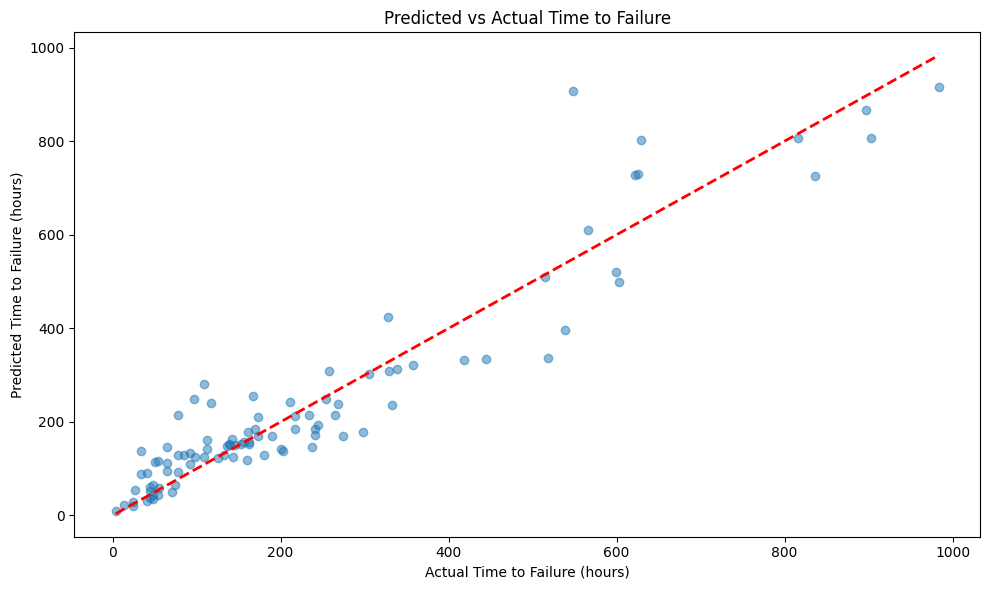

In [18]:

# Calculate our main metrics
mae = mean_absolute_error(y_val, validation_predictions)
mse = mean_squared_error(y_val, validation_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, validation_predictions)

print("Model Performance Metrics:")
print(f"Mean Absolute Error: {mae:.2f} hours")
print(f"Root Mean Squared Error: {rmse:.2f} hours")
print(f"R² Score: {r2:.3f}")


plt.figure(figsize=(10, 6))
plt.scatter(y_val, validation_predictions, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Time to Failure (hours)')
plt.ylabel('Predicted Time to Failure (hours)')
plt.title('Predicted vs Actual Time to Failure')
plt.tight_layout()
plt.show()

In [19]:
# Attempt 1: Increase number of trees and adjust their depth
rf_model_1 = RandomForestRegressor(
    n_estimators=200,          # More trees
    max_depth=15,              # Control tree depth to prevent overfitting
    min_samples_split=5,       # More conservative splitting
    random_state=42,
    n_jobs=-1
)

# Attempt 2: Focus on ensuring each tree has enough samples
rf_model_2 = RandomForestRegressor(
    n_estimators=150,
    min_samples_leaf=4,        # Ensure leaf nodes have enough samples
    max_features='sqrt',       # Use square root of features for each split
    random_state=42,
    n_jobs=-1
)

# Attempt 3: Balance between complexity and simplicity
rf_model_3 = RandomForestRegressor(
    n_estimators=150,
    max_depth=20,
    min_samples_split=3,
    max_features=0.7,          # Use 70% of features for each split
    random_state=42,
    n_jobs=-1
)

# Let's test all three models
models = [rf_model_1, rf_model_2, rf_model_3]
results = []

for i, model in enumerate(models, 1):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    val_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    r2 = r2_score(y_val, val_pred)
    
    results.append({
        'Model': f'Attempt {i}',
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

# Display results in a nice format
results_df = pd.DataFrame(results)
print("Comparison of Model Attempts:")
print(results_df.round(3))

Comparison of Model Attempts:
       Model     MAE    RMSE     R²
0  Attempt 1  51.456  75.320  0.885
1  Attempt 2  55.351  73.172  0.891
2  Attempt 3  50.804  72.438  0.894


Final Model Performance on Test Set:
Mean Absolute Error: 62.18 hours (2.6 days)
Root Mean Squared Error: 81.38 hours (3.4 days)
R² Score: 0.893


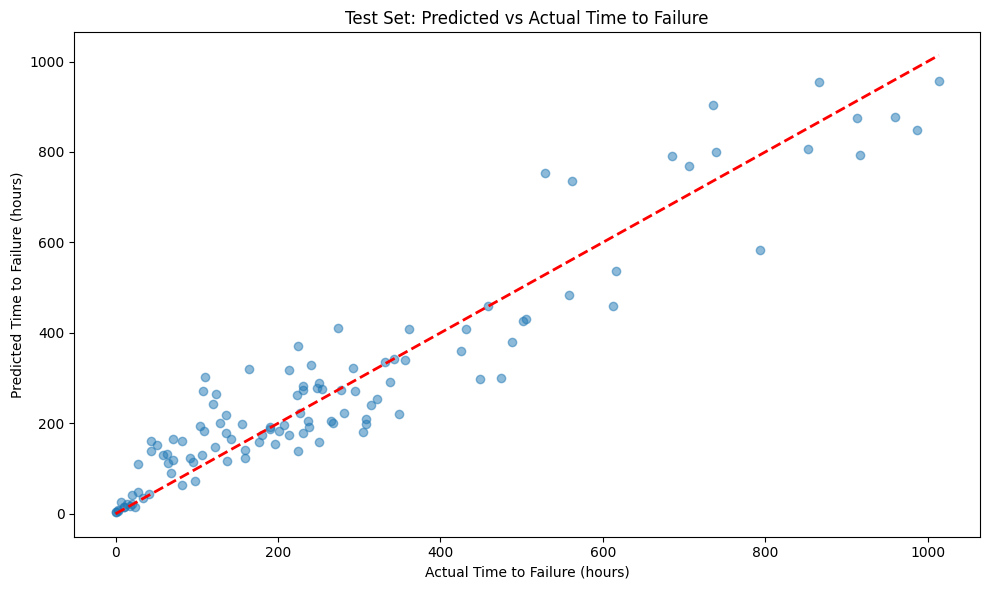

In [20]:
# Get predictions on our test set
test_predictions = rf_model.predict(X_test)

# Calculate final metrics
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

print("Final Model Performance on Test Set:")
print(f"Mean Absolute Error: {test_mae:.2f} hours ({test_mae/24:.1f} days)")
print(f"Root Mean Squared Error: {test_rmse:.2f} hours ({test_rmse/24:.1f} days)")
print(f"R² Score: {test_r2:.3f}")

# Visualize test set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Time to Failure (hours)')
plt.ylabel('Predicted Time to Failure (hours)')
plt.title('Test Set: Predicted vs Actual Time to Failure')
plt.tight_layout()
plt.show()

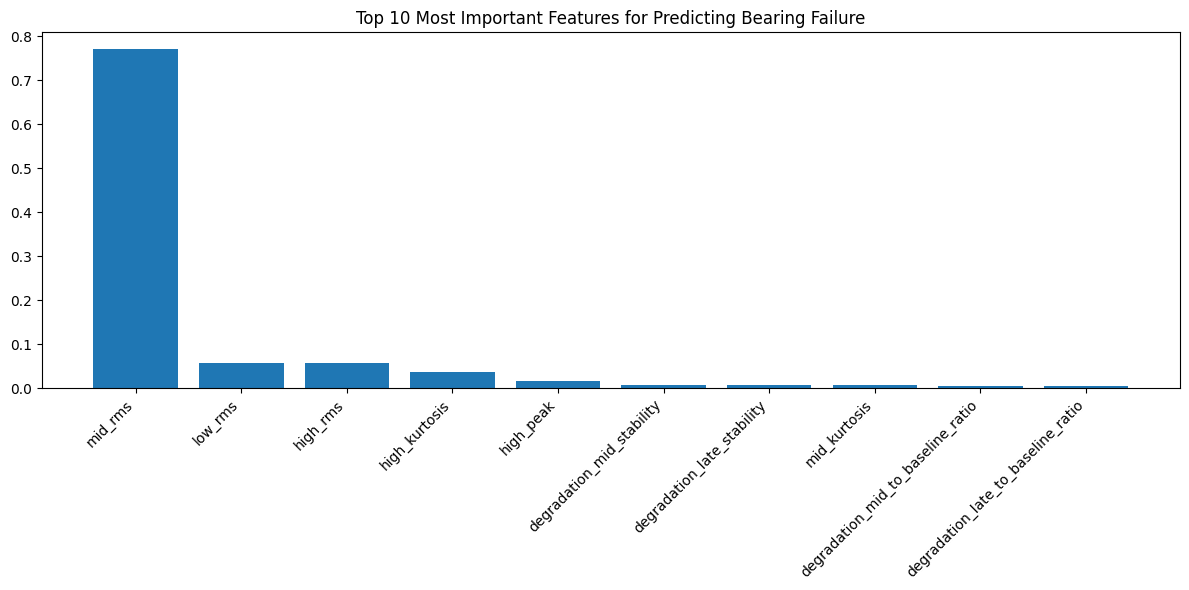


Top 5 Most Important Features:
mid_rms: 0.770
low_rms: 0.057
high_rms: 0.056
high_kurtosis: 0.035
high_peak: 0.016


In [21]:
# Get feature importances from our model
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
})

# Sort by importance and plot top 10
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Important Features for Predicting Bearing Failure')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
for idx, row in feature_importance.head().iterrows():
    print(f"{row['Feature']}: {row['Importance']:.3f}")

In [22]:
def analyze_prediction_timeline(df, rf_model, feature_columns):
    # Dictionary to map bearing IDs to their failure types
    all_bearings = {
        'inner_race_bearing3': 'Inner Race Failure (Set 1, Bearing 3)',
        'roller_bearing4': 'Roller Element Failure (Set 1, Bearing 4)',
        'outer_race_set2_bearing1': 'Outer Race Failure (Set 2, Bearing 1)',
        'outer_race_set3_bearing3': 'Outer Race Failure (Set 3, Bearing 3)'
    }
    
    all_results = []
    
    for bearing_id, failure_type in all_bearings.items():
        # Get data for this bearing
        bearing_mask = df['bearing_id'] == bearing_id
        bearing_data = df[bearing_mask].sort_values('sample_number')
        
        # Check predictions at different life stages
        checkpoints = [0.25, 0.5, 0.75, 0.9]  # 25%, 50%, 75%, and 90% of bearing life
        
        for checkpoint in checkpoints:
            idx = int(len(bearing_data) * checkpoint)
            sample = bearing_data.iloc[idx]
            
            # Make prediction
            features = sample[feature_columns].values.reshape(1, -1)
            predicted_hours = rf_model.predict(features)[0]
            actual_hours = sample['time_to_failure_hours']
            
            all_results.append({
                'Bearing': failure_type,
                'Life Stage': f"{int(checkpoint*100)}% through life",
                'Actual Hours Remaining': round(actual_hours, 1),
                'Predicted Hours': round(predicted_hours, 1),
                'Error (Hours)': round(abs(actual_hours - predicted_hours), 1),
                'Error (Days)': round(abs(actual_hours - predicted_hours)/24, 1),
                'Accuracy (%)': round((1 - abs(predicted_hours - actual_hours)/actual_hours) * 100, 1)
            })
    
    results_df = pd.DataFrame(all_results)
    
    print("Comprehensive Failure Prediction Analysis")
    print("----------------------------------------")
    
    # Print summary for each bearing
    for bearing in all_bearings.values():
        print(f"\n{bearing}:")
        bearing_results = results_df[results_df['Bearing'] == bearing]
        print(bearing_results.to_string(index=False))
    
    # Overall accuracy statistics
    print("\nOverall Prediction Performance:")
    print(f"Average Accuracy: {results_df['Accuracy (%)'].mean():.1f}%")
    print(f"Average Error: {results_df['Error (Days)'].mean():.1f} days")
    
    return results_df

# Run the comprehensive analysis
results = analyze_prediction_timeline(df, rf_model, feature_columns)

c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Rand

Comprehensive Failure Prediction Analysis
----------------------------------------

Inner Race Failure (Set 1, Bearing 3):
                              Bearing       Life Stage  Actual Hours Remaining  Predicted Hours  Error (Hours)  Error (Days)  Accuracy (%)
Inner Race Failure (Set 1, Bearing 3) 25% through life                   271.2            259.8           11.4           0.5          95.8
Inner Race Failure (Set 1, Bearing 3) 50% through life                   179.7            178.8            0.9           0.0          99.5
Inner Race Failure (Set 1, Bearing 3) 75% through life                    88.2             98.5           10.3           0.4          88.3
Inner Race Failure (Set 1, Bearing 3) 90% through life                    34.0             54.1           20.1           0.8          40.8

Roller Element Failure (Set 1, Bearing 4):
                                  Bearing       Life Stage  Actual Hours Remaining  Predicted Hours  Error (Hours)  Error (Days)  Accuracy

c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [23]:
def predict_bearing_failure(model, bearing_readings):
    """
    A simple function to predict bearing failure time based on current sensor readings.
    
    Args:
        model: Our trained Random Forest model
        bearing_readings: Dictionary containing current sensor measurements
                        (should include all 20 features we used for training)
    
    Returns:
        Dictionary containing:
        - Predicted hours until failure
        - Predicted days until failure
        - Confidence level based on how far the prediction is
    """
    # Ensure all required features are present
    required_features = feature_columns  # Our original feature list
    
    # Check if we have all needed measurements
    missing_features = [feat for feat in required_features if feat not in bearing_readings]
    if missing_features:
        return f"Missing required measurements: {missing_features}"
    
    # Create feature array in correct order
    X_new = np.array([[bearing_readings[feat] for feat in feature_columns]])
    
    # Make prediction
    hours_to_failure = model.predict(X_new)[0]
    days_to_failure = hours_to_failure / 24
    
    # Determine confidence level based on prediction timeframe
    if hours_to_failure <= 168:  # Within a week
        confidence = "High (within 1-week prediction window)"
    elif hours_to_failure <= 336:  # Within two weeks
        confidence = "Medium (1-2 week prediction window)"
    else:
        confidence = "Lower (long-term prediction)"
        
    return {
        'predicted_hours': round(hours_to_failure, 1),
        'predicted_days': round(days_to_failure, 1),
        'confidence_level': confidence
    }

# Let's create an example of how to use it
# First, let's get a real example from our dataset for demonstration
sample_readings = df.iloc[0][feature_columns].to_dict()

# Make a prediction with these readings
prediction = predict_bearing_failure(rf_model, sample_readings)

print("Example Bearing Failure Prediction:")
print(f"Hours until failure: {prediction['predicted_hours']}")
print(f"Days until failure: {prediction['predicted_days']}")
print(f"Confidence Level: {prediction['confidence_level']}")

# Let's also show what measurements are needed
print("\nRequired measurements for prediction:")
for feature in feature_columns:
    print(f"- {feature}")

Example Bearing Failure Prediction:
Hours until failure: 347.3
Days until failure: 14.5
Confidence Level: Lower (long-term prediction)

Required measurements for prediction:
- low_rms
- low_peak
- low_crest
- low_kurtosis
- mid_rms
- mid_peak
- mid_crest
- mid_kurtosis
- high_rms
- high_peak
- high_crest
- high_kurtosis
- degradation_mid_to_baseline_ratio
- degradation_late_to_baseline_ratio
- degradation_early_rate
- degradation_mid_rate
- degradation_late_rate
- degradation_early_stability
- degradation_mid_stability
- degradation_late_stability


c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [24]:
# Example 1 - Near failure (High Confidence)
late_stage_sample = df[df['time_to_failure_hours'] <= 100].iloc[0][feature_columns].to_dict()
prediction = predict_bearing_failure(rf_model, late_stage_sample)
print("Example 1 - Near Failure:")
print(f"Hours until failure: {prediction['predicted_hours']}")
print(f"Days until failure: {prediction['predicted_days']}")
print(f"Confidence Level: {prediction['confidence_level']}\n")

# Example 2 - Medium term (Medium Confidence)
mid_stage_sample = df[(df['time_to_failure_hours'] > 168) & (df['time_to_failure_hours'] <= 336)].iloc[0][feature_columns].to_dict()
prediction = predict_bearing_failure(rf_model, mid_stage_sample)
print("Example 2 - Medium Term:")
print(f"Hours until failure: {prediction['predicted_hours']}")
print(f"Days until failure: {prediction['predicted_days']}")
print(f"Confidence Level: {prediction['confidence_level']}\n")

# Example 3 - Early stage (Lower Confidence)
early_stage_sample = df[df['time_to_failure_hours'] > 500].iloc[0][feature_columns].to_dict()
prediction = predict_bearing_failure(rf_model, early_stage_sample)
print("Example 3 - Early Stage:")
print(f"Hours until failure: {prediction['predicted_hours']}")
print(f"Days until failure: {prediction['predicted_days']}")
print(f"Confidence Level: {prediction['confidence_level']}")

Example 1 - Near Failure:
Hours until failure: 115.6
Days until failure: 4.8
Confidence Level: High (within 1-week prediction window)

Example 2 - Medium Term:
Hours until failure: 327.2
Days until failure: 13.6
Confidence Level: Medium (1-2 week prediction window)

Example 3 - Early Stage:
Hours until failure: 1012.8
Days until failure: 42.2
Confidence Level: Lower (long-term prediction)


c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Ahmed Ayaz\Vibration-Analysis-System\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [25]:
# Let's verify the data for each example
print("Example 1 (Near Failure) Source Data:")
near_failure_data = df[df['time_to_failure_hours'] <= 100].iloc[0]
print(f"Bearing ID: {near_failure_data['bearing_id']}")
print(f"Actual time to failure: {near_failure_data['time_to_failure_hours']} hours")

print("\nExample 2 (Medium Term) Source Data:")
mid_term_data = df[(df['time_to_failure_hours'] > 168) & (df['time_to_failure_hours'] <= 336)].iloc[0]
print(f"Bearing ID: {mid_term_data['bearing_id']}")
print(f"Actual time to failure: {mid_term_data['time_to_failure_hours']} hours")

print("\nExample 3 (Early Stage) Source Data:")
early_stage_data = df[df['time_to_failure_hours'] > 500].iloc[0]
print(f"Bearing ID: {early_stage_data['bearing_id']}")
print(f"Actual time to failure: {early_stage_data['time_to_failure_hours']} hours")

Example 1 (Near Failure) Source Data:
Bearing ID: inner_race_bearing3
Actual time to failure: 98.33333333333333 hours

Example 2 (Medium Term) Source Data:
Bearing ID: inner_race_bearing3
Actual time to failure: 335.5 hours

Example 3 (Early Stage) Source Data:
Bearing ID: outer_race_set3_bearing3
Actual time to failure: 1053.8333333333333 hours


In [27]:
# Save model
joblib.dump(rf_model, 'bearing_failure_predictor.joblib')

['bearing_failure_predictor.joblib']

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create directory for plots if it doesn't exist
plots_dir = 'model_results_plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# 1. Overall Prediction Accuracy Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Time to Failure (hours)')
plt.ylabel('Predicted Time to Failure (hours)')
plt.title('Model Prediction Accuracy: Predicted vs Actual Failure Times')
plt.savefig(f'{plots_dir}/prediction_accuracy.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Feature Importance Plot
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features for Failure Prediction')
plt.savefig(f'{plots_dir}/feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Prediction Error Distribution
prediction_errors = abs(y_test - test_predictions)
plt.figure(figsize=(10, 6))
sns.histplot(prediction_errors/24, bins=30)  # Converting to days
plt.xlabel('Prediction Error (days)')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.savefig(f'{plots_dir}/error_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Time-Based Prediction Accuracy
results_df = pd.DataFrame({
    'Time_Remaining': y_test,
    'Prediction': test_predictions,
    'Error': abs(y_test - test_predictions)
})
results_df['Error_Days'] = results_df['Error']/24

plt.figure(figsize=(10, 6))
plt.scatter(results_df['Time_Remaining'], results_df['Error_Days'], alpha=0.5)
plt.xlabel('Time Until Failure (hours)')
plt.ylabel('Prediction Error (days)')
plt.title('Prediction Error vs Time Until Failure')
plt.savefig(f'{plots_dir}/error_vs_time.png', dpi=300, bbox_inches='tight')
plt.close()

print(f"Plots have been saved to the '{plots_dir}' directory")

Plots have been saved to the 'model_results_plots' directory


In [32]:
# 1. "Time to Failure" Status Plot
plt.figure(figsize=(12, 6))
statuses = ['Critical (0-7 days)', 'Warning (7-14 days)', 'Monitor (14+ days)']
counts = [
    len(test_predictions[test_predictions <= 168]),  # 7 days
    len(test_predictions[(test_predictions > 168) & (test_predictions <= 336)]),  # 14 days
    len(test_predictions[test_predictions > 336])
]

colors = ['red', 'orange', 'green']
plt.bar(statuses, counts, color=colors)
plt.title('Distribution of Bearing Health Status')
plt.ylabel('Number of Bearings')
plt.xticks(rotation=45)
plt.savefig(f'{plots_dir}/bearing_status_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Timeline Visualization
plt.figure(figsize=(15, 6))

# Create DataFrame with numeric index
timeline_data = pd.DataFrame({
    'Days_to_Failure': y_test/24,
    'Predicted_Days': test_predictions/24,
    'Bearing_ID': df.iloc[y_test.index]['bearing_id']
}).sort_values('Days_to_Failure').reset_index(drop=True)

# Plot each bearing type
for bearing in timeline_data['Bearing_ID'].unique():
    data = timeline_data[timeline_data['Bearing_ID'] == bearing]
    plt.plot(data.index, data['Days_to_Failure'], 
            'o-', label=f'Actual {bearing}', alpha=0.6, markersize=4)
    plt.plot(data.index, data['Predicted_Days'], 
            's--', label=f'Predicted {bearing}', alpha=0.6, markersize=4)

plt.axhline(y=7, color='r', linestyle=':', label='Critical (7 days)')
plt.axhline(y=14, color='orange', linestyle=':', label='Warning (14 days)')
plt.title('Bearing Failure Timeline by Bearing Type')
plt.ylabel('Days until Failure')
plt.xlabel('Sample Number')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'{plots_dir}/failure_timeline_by_bearing.png', dpi=300, bbox_inches='tight')
plt.close()

In [33]:
# Print comparison of actual vs predicted values for each bearing
for bearing in timeline_data['Bearing_ID'].unique():
   data = timeline_data[timeline_data['Bearing_ID'] == bearing]
   print(f"\nResults for {bearing}:")
   print("Sample | Actual Days | Predicted Days | Error (Days)")
   print("-" * 55)
   for idx, row in data.iterrows():
       print(f"{idx:6d} | {row['Days_to_Failure']:10.1f} | {row['Predicted_Days']:13.1f} | {abs(row['Days_to_Failure'] - row['Predicted_Days']):11.1f}")
   
   # Calculate average error for this bearing
   avg_error = abs(data['Days_to_Failure'] - data['Predicted_Days']).mean()
   print(f"\nAverage prediction error for {bearing}: {avg_error:.1f} days")


Results for inner_race_bearing3:
Sample | Actual Days | Predicted Days | Error (Days)
-------------------------------------------------------
     0 |        0.0 |           0.2 |         0.2
     1 |        0.0 |           0.2 |         0.2
     2 |        0.1 |           0.3 |         0.2
     4 |        0.3 |           1.1 |         0.8
    11 |        1.0 |           0.6 |         0.4
    13 |        1.1 |           2.0 |         0.9
    21 |        2.7 |           4.7 |         2.0
    25 |        3.4 |           2.6 |         0.7
    26 |        3.4 |           6.7 |         3.4
    27 |        3.8 |           5.2 |         1.4
    29 |        4.1 |           3.0 |         1.1
    33 |        4.5 |           7.6 |         3.1
    39 |        5.7 |           9.1 |         3.5
    43 |        6.5 |           8.3 |         1.8
    44 |        6.6 |           5.1 |         1.5
    47 |        7.3 |           6.6 |         0.7
    49 |        7.9 |           8.0 |         0.1
    51 